# 매개변수 갱신
- 확률적 경사하강법(Stochastic Gradient Descent)의 단점과 새로운 매개변수 최적화 기법

### SGD 구현하기
- 하나의 계층으로 구현하기 위해 Python Class로 구현하기
- 가중치 매개변수를 갱신하는 식 : w = w - dL/dW*lr
- 가중치를 갱신하는 클래스를 분리해 구현하면 기능을 모듈화하기 좋다
- 가중치를 갱신하는 방법을 SGD -> Momentum으로 변경한다면 갱신 클래스만 변경하기 된다

In [202]:
class SGD:
    def __init__(self,lr=0.01):
        self.lr = lr # 초기화 때 입력받는 인수 '학습률'
        
    def update(self,params,grads): # 가중치 매개변수를 갱신하는 식
        for key in params.keys():
            params[key] -= grads[key] * self.lr

SGD의 단점을 확인하기 위해 비등방성 함수에서 최적화 과정을 시각화하자
- 지그재그로 최적화가 갱신되는 경로를 확인하고 하였으나 어떠한 이유에선지 지그재그로 갱신되는 모습이 보이지 않음
- 하지만 시각화 과정을 통해 최적화 갱신 경로가 상당히 비효율적인 것은 확인할 수 있음

In [203]:
def function_2(x):
    return x[0]**2 / 20.0 + x[1]**2

def numerical_gradient(f,x):
    h = 1e-4
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=["multi_index"],op_flags=["readwrite"])
    
    while not it.finished:
        idx = it.multi_index
        obj_val = x[idx]
        x[idx] = float(obj_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = float(obj_val) - h
        fxh2 = f(x) # f(x-h)
        
        x[idx] = float(obj_val) # 값 초기화
        grad[idx] = (fxh1 - fxh2) / (2*h)
        it.iternext() # False 반복문 종료
    return grad

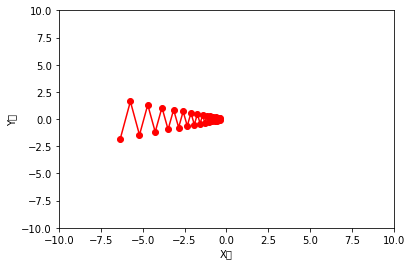

In [204]:
import numpy as np
import matplotlib.pylab as plt
plt.xlabel("X축") ; plt.ylabel("Y축")
plt.xlim(-10,10) ; plt.ylim(-10,10)
x = np.array([-7.0,2.0])
lr = 0.95

x1_history = [] ; x2_history = []

for i in range(30):
    x -= numerical_gradient(function_2,x) * lr
    x1_history.append(x[0]) ; x2_history.append(x[1])
plt.plot(x1_history,x2_history,'o-',color="red")

### 모멘텀을 통한 SGD의 단점 해결
- 새로운 v 변수의 등장, 속도에 해당함
- momentum * v 항은 물체가 아무런 힘을 받지 않을 때 서서히 하강시키는 역할
- SGD의 단점인 지그재그 움직임을 줄여준다

In [205]:
class Momentum:
    def __init__(self,lr = 0.01, momentum = 0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self,params,grads):
        if self.v is None: # v가 None이라면 v 생성하기, 매개변수와 같은 구조의 데이터를 저장
            self.v = {} 
            for key,val in params.items():
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]        

- 학습률을 0.01로 설정하고, 매개변수 갱신을 200회 한 결과
- SGD는 아직 최솟값인 (0,0)에 도달하지 못했지만, 모멘텀은 이미 도달하였다
- 모멘텀 방법의 효율성 확인 가능

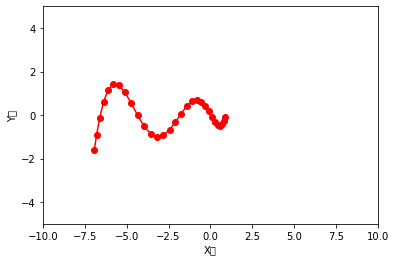

In [206]:
import numpy as np
import matplotlib.pylab as plt
plt.xlabel("X축") ; plt.ylabel("Y축")
plt.xlim(-10,10) ; plt.ylim(-5,5)
x = np.array([-7.0,-2.0])
lr = 0.1
momentum = 0.9
v = 0
x1_history = [] ; x2_history = []
for i in range(30):
    v = momentum * v - numerical_gradient(function_2,x) * lr
    x += v
    x1_history.append(x[0]) ; x2_history.append(x[1])
plt.plot(x1_history,x2_history,'o-',color="red")

### AdaGrad
- 학습률(learning rate)이 너무 작으면 학습 시간이 길어지고, 너무 크면 발산해 학습이 제대로 X
- 학습률 감소(learning rate decay) : 위 문제를 해결하는 학습을 진행하면서 점차 학습률을 줄여감
- 일괄적으로 전체 학습률을 낮추는 대신 각각 매개변수에 맞게 조정하는 방법, AdaGrad
- 처음에는 큰 폭으로 움직이지며 크게 갱신되지만 점차 갱신 강도가 빠르게 약해지고 지그재그 움직임 감소

In [207]:
class AdaGrad:
    def __init__(self,lr=0.01):
        self.lr = lr
        self.h = None
    def update(self,params,grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7) # 0으로 나눠는 division zero 해결

- 학습률을 0.01로 설정하고, 매개변수 갱신을 5000회 한 결과
- AdaGrad는 최솟값에 도달하지 못했음
- AdaGrad의 갱신 과정을 성공적으로 시각화하지 못한 것 같음

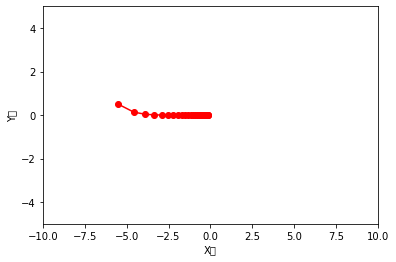

In [208]:
import numpy as np
import matplotlib.pylab as plt
plt.xlabel("X축") ; plt.ylabel("Y축")
plt.xlim(-10,10) ; plt.ylim(-5,5)
x = np.array([-7.0,2.0])
x1_history = [] ; x2_history = []
lr = 1.5
h = 0
for i in range(30):
    h += numerical_gradient(function_2,x) ** 2
    x -= lr * numerical_gradient(function_2,x) / (np.sqrt(h) + 1e-7)
    x1_history.append(x[0]) ; x2_history.append(x[1])
plt.plot(x1_history,x2_history,'o-',color="red")

### Optimizer 클래스로 매개변수 갱신
- Optimizer 클래스로 갱신과정을 모듈화한 것을 시각화해보자

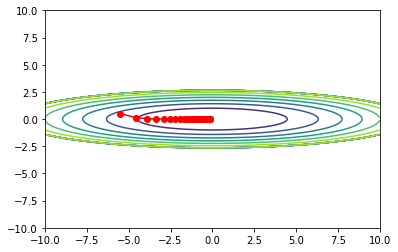

In [216]:
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

def f(x):
    return x[0]**2 / 20.0 + x[1]**2

x = np.array([-7.0,2.0])
params = {} # 매개변수 딕셔너리
grads = {} # 매개변수 기울기 딕셔너리

x1_history = [] # x1 변수 갱신과정 기록
x2_history = [] # x2 변수 갱신과정 기록

params["x1"] = x[0] ; params["x2"] = x[1]

#grads['x1'] = 0 ; grads['x2'] = 0

#optimizer = SGD(lr=0.95)
#optimizer = Momentum(lr=0.1)
optimizer = AdaGrad(lr=1.5)

for i in range(30): # 매개변수 100회 갱신
    
    grads['x1'] = numerical_gradient(f,np.array([params["x1"],params["x2"]]))[0]
    grads['x2'] = numerical_gradient(f,np.array([params["x1"],params["x2"]]))[1]
    
    optimizer.update(params,grads)
    
    x1_history.append(params["x1"])
    x2_history.append(params["x2"])

X = np.arange(-10.0,10.0,0.01)
Y = np.arange(-5.0,5.0,0.01)
X_grid, Y_grid = np.meshgrid(X, Y) # 2차원 그리드 좌표

Z = f(np.array([X_grid,Y_grid]))
maks = Z > 7
Z[mask] = 0 # 7 넘는 값은 제외
plt.contour(X_grid,Y_grid,Z)

plt.xlim(-10,10) ; plt.ylim(-10,10)
plt.plot(x1_history,x2_history,"o-",color="red")

(-10.0, 10.0)

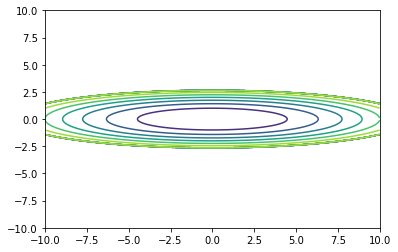

In [200]:
X = np.arange(-10.0,10.0,0.01)
Y = np.arange(-5.0,5.0,0.01)
X_grid, Y_grid = np.meshgrid(X, Y) # 2차원 그리드 좌표
Z = f(np.array([X_grid,Y_grid]))
maks = Z > 7
Z[mask] = 0 # 7 넘는 값은 제외

plt.contour(X_grid,Y_grid,Z)
plt.xlim(-10,10) ; plt.ylim(-10,10)

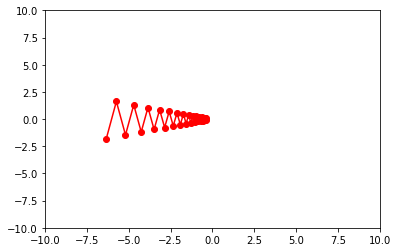

In [214]:
import numpy as np
import matplotlib.pyplot as plt

def f(x):
    return x[0]**2 / 20.0 + x[1]**2

x = np.array([-7.0,2.0])
params = {} ; grads = {} # 매개변수, 기울기 딕셔너리

x1_history = [] ; x2_history = [] # 매개변수 갱신과정 기록 

params["x1"] = x[0] ; params["x2"] = x[1]

optimizer = SGD(lr=0.95)
#optimizer = Momentum(lr=0.1)
#optimizer = AdaGrad(lr=1.5)

for i in range(30): # 매개변수 100회 갱신
    
    grads['x1'] = numerical_gradient(f,np.array([params["x1"],params["x2"]]))[0]
    grads['x2'] = numerical_gradient(f,np.array([params["x1"],params["x2"]]))[1]
    
    optimizer.update(params,grads)
    
    x1_history.append(params["x1"])
    x2_history.append(params["x2"])
    
plt.xlim(-10,10) ; plt.ylim(-10,10)
plt.plot(x1_history,x2_history,"o-",color="red") # 매개변수갱신과정 시각화

### MNIST 데이터셋으로 본 갱신방법 비교
- 단순한 넘파이 배열 데이터가 아닌 손글씨 숫자 인식을 대상으로 최적화 기법 비교

====== iteration:0======
SGD:2.3787182629549224
Momentum:2.365497023409812
AdaGrad:2.1657921035962415
====== iteration:100======
SGD:1.3342296505682267
Momentum:0.32267358500882326
AdaGrad:0.15108138566118945
====== iteration:200======
SGD:0.6614908795024594
Momentum:0.19922972065445557
AdaGrad:0.07752700536081221
====== iteration:300======
SGD:0.5499649726349747
Momentum:0.20104843045957826
AdaGrad:0.10596193505243828
====== iteration:400======
SGD:0.44469787254732546
Momentum:0.1296713681391192
AdaGrad:0.054466980247647706
====== iteration:500======
SGD:0.3441615463147847
Momentum:0.0863061715217591
AdaGrad:0.03312485990559902
====== iteration:600======
SGD:0.24144976995508774
Momentum:0.07211722740423268
AdaGrad:0.023526597773904735
====== iteration:700======
SGD:0.2910176712467467
Momentum:0.1593356643165985
AdaGrad:0.08647841491260336
====== iteration:800======
SGD:0.3024600950787675
Momentum:0.1737535399919296
AdaGrad:0.05922991519902914
====== iteration:900======
SGD:0.224625185

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 49688 missing from curre

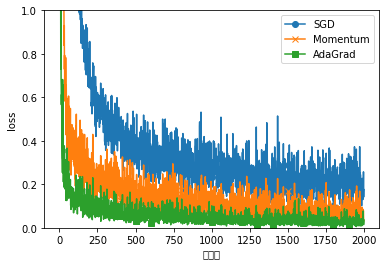

In [7]:
import os
import sys
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import *

# 데이터 읽어오기
(x_train,t_train),(x_test,t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000

# 최적화 클래스 호출하기
optimizers = {}
optimizers["SGD"] = SGD()
optimizers["Momentum"] = Momentum()
optimizers["AdaGrad"] = AdaGrad()

# MultiLayerNet : 완전연결 신경망
networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(input_size=784,hidden_size_list=[100, 100, 100, 100], output_size=10)
    train_loss[key] = []
    
# 훈련시작
for i in range(max_iterations):
    # 미니 배치 학습
    batch_mask = np.random.choice(train_size,batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 값을 토대로 매개변수값 갱신
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch,t_batch)
        optimizers[key].update(networks[key].params,grads)
        
        loss = networks[key].loss(x_batch,t_batch)
        train_loss[key].append(loss)
        
    # 100의 배수 번째 반복마다 손실함수 값 출력
    if i % 100 == 0:
        print("====== iteration:"+str(i)+"======")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch,t_batch)
            print(key + ":" + str(loss))

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 49688 missing from curre

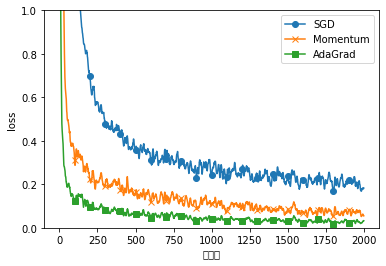

In [10]:
# 그래프 그리기 - smooth_curve 매서드를 이용해서 그래프를 단순화
markers = {"SGD":"o","Momentum":"x","AdaGrad":"s"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x,smooth_curve(train_loss[key]),marker=markers[key],markevery=100,label=key)
plt.xlabel("반복수")
plt.ylabel("loss")
plt.ylim(0,1)
plt.legend()